# Navid por



In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# % matplotlib inline

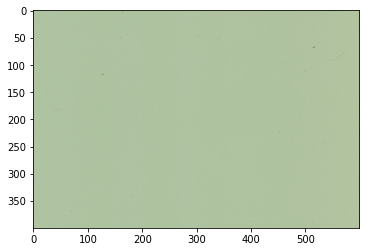

In [32]:
image = cv2.imread(r'C:\Users\Acer\Desktop\navidpor\Dosimetry-Films\30Gy.tif')
# since im going to use plt for shows in pdf and not new tab
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#cropping the image centeral part
image=image[600:1000,100:700]
plt.imshow(image)

<Figure size 432x288 with 0 Axes>

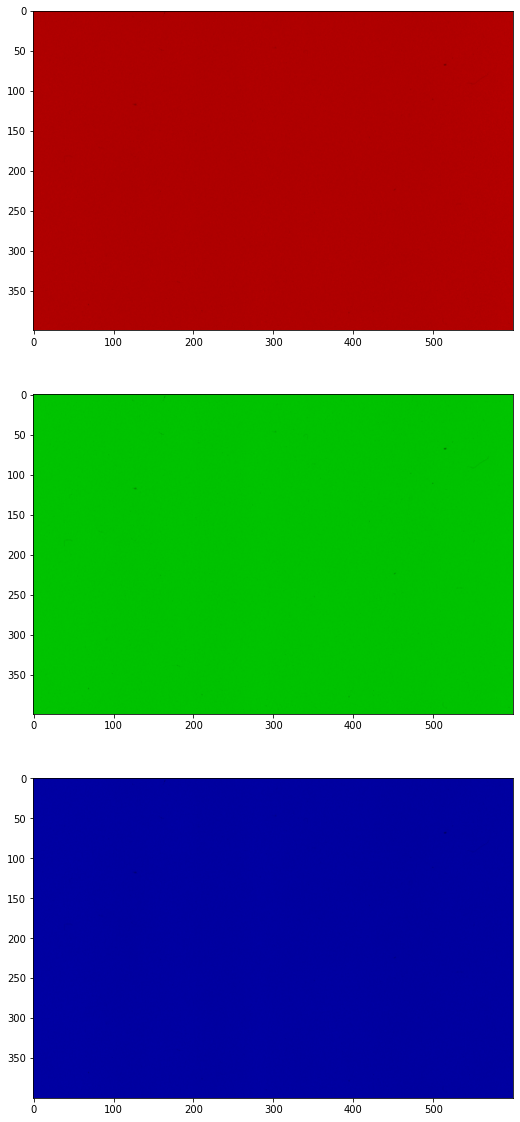

In [36]:
r = image.copy()
# set green and red channels to 0
r[:, :, 1] = 0
r[:, :, 2] = 0


g = image.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

b = image.copy()
# set blue and green channels to 0
b[:, :, 0] = 0
b[:, :, 1] = 0



plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, ax = plt.subplots(3,1,figsize=(50,20)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
ax[0].imshow(r)
ax[1].imshow(g)
ax[2].imshow(b);


In [43]:
r[:,:,0].mean(),r[:,:,0].std()

(175.521925, 2.116794580108093)

In [ ]:


# As of Jan 18, 2022: 
    # img is reading 8-bit instead of 16 bit so I need to fix that
    # this is just the beginning part of the translated matlab code


# This is the beginning of some real and psuedo code for the dosimetry app!!
# Adapting from the matlab code, just for a starting point
# CLK Dec 2021


# Import libraries
import numpy as np
from PIL import Image
import pandas as pd

# load image and create array of x y r g b 
img_path = "/Users/christinekuryla/Documents/Columbia/DUVS/210412_Lumen_calibration_4_5uW003.tif"
img = Image.open(img_path)
img_arr = np.array(img) # array with x y r g b 

# load csv with [film_index, dose, xmin, xmax, ymin, ymax]
# use pandas and create a dataframe df from the csv
film_coord_path = "/Users/christinekuryla/Documents/Columbia/DUVS/orig_image_coords_dose.csv"
img_data = pd.read_csv(film_coord_path)
df = pd.DataFrame(img_data)


# Define a function that determines the average pixel value (for whatever channel)
# for the specified "area" (the coordinates will be where each film is!)
    # note: if we have an amorphous blob istead of a rectangle as the range, we can just do this function with a vector containing each pixel in the film

def film_channel_mean(color_channel, film_index, xmin, xmax, ymin, ymax):
    # reset variable to 0 for each film
        sum_of_pixels = 0
    # sum over each pixel in range of film
        for x in np.linspace(xmin, xmax, (xmax-xmin+1)).astype(int):   # for x in film_index.x_pixel_range:
            for y in np.linspace(ymin, ymax, (ymax-ymin+1)).astype(int):   #film_index.y_pixel_range:
                #channel value at (each x_pixel_range, y_pixel_range)
                pixel_value = img_arr[x,y][color_channel]
                # add value to total value of all pixels incrementally
                sum_of_pixels = sum_of_pixels + pixel_value            
    # total number of pixels in area is just the number of pixels in rectangle
        total_number_of_pixels = (xmax - xmin) * (ymax - ymin)
    # divide sum by total number to calculate and return mean
        mean_pixel_value = sum_of_pixels / total_number_of_pixels
        return mean_pixel_value

# Use function to pass mean values into df in appropriate places

# Create (initialize) an array as place holder in df then create column for raw mean in df
blank_float_for_df  = np.linspace(0, 16, len(img_data.xmin)).astype(float)
df["raw_mean_red"]=blank_float_for_df
df["raw_mean_green"]=blank_float_for_df
df["raw_mean_blue"]=blank_float_for_df

# Apply the function created above to calculate the mean value for each film i 
# and place the value in the df for each color channel r,g,b
# Note that in img_data, red is indexed as 0, green is 1, blue is 2
for i in img_data.film_index:
    df["raw_mean_red"][i] = film_channel_mean(color_channel = 0, 
                                            film_index = img_data['film_index'][i], 
                                            xmin = img_data['xmin'][i], xmax = img_data['xmax'][i], 
                                            ymin = img_data['ymin'][i], ymax = img_data['ymax'][i])
    df["raw_mean_green"][i] = film_channel_mean(color_channel = 1, 
                                            film_index = img_data['film_index'][i], 
                                            xmin = img_data['xmin'][i], xmax = img_data['xmax'][i], 
                                            ymin = img_data['ymin'][i], ymax = img_data['ymax'][i])
    df["raw_mean_blue"][i] = film_channel_mean(color_channel = 2, 
                                            film_index = img_data['film_index'][i], 
                                            xmin = img_data['xmin'][i], xmax = img_data['xmax'][i], 
                                            ymin = img_data['ymin'][i], ymax = img_data['ymax'][i])
    
# Plot them!
df.plot(x="dose", y=["raw_mean_blue", "raw_mean_red", "raw_mean_green"])


# Then fit the curves for x = dose, y = red_avg/blue_avg/green_avg
# Convert to OD, etc
# WIll adapt the rest of the code with the corresponding functions/fitting capability in python!

# ***The following equations are incorrect*** 
# And I just plotted for funsies to get an idea of qualitative shape

# from matlab code: This converts to OD and netOD for curve fitting, OD is essentially the color density (CD).  
# This was a 16 bit TIFF, hence the divide by 65535=2^16
# OD_red=-log10(raw_mean_red/65535);

df["OD_red"] = -1 * np.log10(df.raw_mean_red/65535)
df["OD_green"] = -1 * np.log10(df.raw_mean_green/65535)
df["OD_blue"] = -1 * np.log10(df.raw_mean_blue/65535)


df.plot(x="dose", y=["OD_blue", "OD_red", "OD_green"])

# this subtracts the value of the unexposed 0 dose film
# ???why do we do net od vs subtract the mean???
#net_OD_red = OD_red - df.OD_red[0];


# Add 3 columns net_OD_color to df that subtracts the value from the unexposed dose 0 film df.OD_color[0]
df["net_OD_red"] = df.OD_red - df.OD_red[0]
df["net_OD_green"] = df.OD_green - df.OD_green[0]
df["net_OD_blue"] = df.OD_blue - df.OD_blue[0]


df.plot(x="dose", y=["net_OD_blue", "net_OD_red", "net_OD_green"])











# df.mean_red - df.mean_red[0]

# =============================================================================
# 
# # Practice File 20211206 -- Youtube "Python in 1 hour"
# 
# # https://letmaik.github.io/rawpy/api/rawpy.RawPy.html
# # raw_color(y,x)
# # class or load or whatever: rawpy.Rawpy
# # Image J ? https://forum.image.sc/t/imagej-analyze-measure-output-value-calculation/55426
# 
# print("helloworld")
# 
# #https://datascience-enthusiast.com/R/pandas_datatable.html
# 
# 
# =============================================================================

# =============================================================================
# """
# %% Fit equations
# 
# %%% these are the options for curve fitting
# fo = fitoptions('Method','NonlinearLeastSquares',...
#                'Lower',[0 0 0],...
#                'Upper',[Inf Inf Inf],...
#                'StartPoint',[10 10 10]);
# 
# %%% this defines the equation to fit to
# ft = fittype('(a+(b*x))/(x+c)','options',fo);
# %%% this does the curve fit and returns the parameters, variable names with
# %%% xray are carry over from old versions of this code
# """
# =============================================================================













